In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import time

from itertools import product
import qutip as qt

import h5py
from datetime import datetime
import sys
import os
import shutil
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")
sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1\current_measurements")


import current_measurements.src.src_current_measurement_simulations
importlib.reload(current_measurements.src.src_current_measurement_simulations);
from current_measurements.src.src_current_measurement_simulations import CurrentMeasurementSimulation

import current_measurements.src.src_current_measurement_simulations_particle_sector
importlib.reload(current_measurements.src.src_current_measurement_simulations_particle_sector);
from current_measurements.src.src_current_measurement_simulations_particle_sector import CurrentMeasurementSimulationParticleSector


In [2]:
def convert_particle_sector_to_reduced_density_matrix(psi_4particle, 
                                                      basis_4particle, 
                                                      reduced_qubit_indices, 
                                                      num_qubits=8,
                                                      num_levels=5):
    """
    More efficient version that groups states by their traced configurations
    """
    from collections import defaultdict
    
    traced_qubits = [i for i in range(num_qubits) if i not in reduced_qubit_indices]
    
    # Group states by (reduced_config, traced_config)
    state_groups = defaultdict(list)
    
    for i, full_state in enumerate(basis_4particle):
        reduced_part = tuple(full_state[j] for j in reduced_qubit_indices)
        traced_part = tuple(full_state[j] for j in traced_qubits)
        state_groups[(reduced_part, traced_part)].append(i)
    
    # Generate basis for reduced qubits
    reduced_basis = list(product(range(num_levels), repeat=len(reduced_qubit_indices)))
    dim_reduced = len(reduced_basis)
    rho_reduced = np.zeros((dim_reduced, dim_reduced), dtype=complex)
    
    # Build density matrix
    for alpha, reduced_alpha in enumerate(reduced_basis):
        for beta, reduced_beta in enumerate(reduced_basis):
            
            matrix_element = 0.0
            
            # Sum over all traced configurations
            all_traced_configs = set()
            for (red_part, traced_part), indices in state_groups.items():
                if red_part == reduced_alpha or red_part == reduced_beta:
                    all_traced_configs.add(traced_part)
            
            for traced_config in all_traced_configs:
                # Get coefficients for states with this traced configuration
                coeff_alpha = sum(psi_4particle[i] for i in state_groups.get((reduced_alpha, traced_config), []))
                coeff_beta = sum(psi_4particle[i] for i in state_groups.get((reduced_beta, traced_config), []))
                
                matrix_element += coeff_alpha * np.conj(coeff_beta)
            
            rho_reduced[alpha, beta] = matrix_element
    
    return qt.Qobj(rho_reduced, dims=[[num_levels]*len(reduced_qubit_indices), [num_levels]*len(reduced_qubit_indices)])

In [3]:
config_filename = 'current_correlations_config.json'

with open(config_filename, 'r') as f:
    config = json.load(f)

coupling_point = 'coupling_point_4'


coupling_point_config = config[coupling_point]


In [4]:


correlation_pairs = []
for i in range(1, 8):
    for j in range(i + 2, 8):
        correlation_pairs.append(((i, i+1), (j,j+1)))



In [5]:
correlation_pair_to_simulation = {}


In [6]:
### extract simulation data

simulation_config = coupling_point_config['simulation_config']

num_levels = simulation_config['num_levels']
num_qubits = simulation_config['num_qubits']
num_particles = simulation_config['num_particles']

U = simulation_config['U'] * 2  *np.pi
times = np.linspace(simulation_config['time_start'], simulation_config['time_stop'], simulation_config['time_num_points'])

J = []
J_parallel = []

psi0 = simulation_config['psi0']
T1 = simulation_config['T1']
T2 = simulation_config['T2']

coupling_dict = coupling_point_config['coupling']

for i in range(num_qubits-1):
    J_key = f'J_{i+1}{i+2}'
    J_parallel_key = f'J_{i+1}{i+3}'

    if J_key in coupling_dict:
        J.append(coupling_dict[J_key])

    if J_parallel_key in coupling_dict:
        J_parallel.append(coupling_dict[J_parallel_key])

if not len(J) == num_qubits - 1:
    raise ValueError(f'coupling strengths J not properly specified in config file. Needs all pairs J_<i><i+1>. Given length: {len(J)}')

if not len(J_parallel) == num_qubits - 2:
    raise ValueError(f'coupling strengths J_parallel not properly specified in config file. Needs all pairs J_<i><i+2>. Given length: {len(J_parallel)}')

J = np.array(J)*2*np.pi
J_parallel = np.array(J_parallel)*2*np.pi



In [7]:
# create initial state from diagonalizing the full Hamiltonian

simulation = CurrentMeasurementSimulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times,
                                          [1,2], [3,4], psi0=psi0, T1=T1, T2=T2)

psi0_state = simulation.psi0

psi0_state

processing psi0, given type: <class 'int'>


MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [146]:
def calculate_current_correlation_simulation(annihilation_operators, number_operators, initial_state, 
                                             J, J_parallel, U, measurement_detuning, readout_pair_1, readout_pair_2):
    # Initialize timing
    start_time = time.time()
    last_time = start_time

    H_BS_reduced = 0

    q1, q2 = readout_pair_1
    q3, q4 = readout_pair_2
    qubit_indices = [q1, q2, q3, q4]

    print(f'creating Hamiltonian, time elapsed: {time.time() - last_time:.3f}s')
    last_time = time.time()
    
    for i in range(len(number_operators)):
        a_i = annihilation_operators[i]
        q_i = qubit_indices[i]
        for j in range(i+1, len(number_operators)):
            q_j = qubit_indices[j]
            a_j = annihilation_operators[j]
            coupling = 0
            if abs(q_i - q_j) == 1:
                coupling = J[min(q_i, q_j)]

            if abs(q_i - q_j) == 2:
                coupling = J_parallel[min(q_i, q_j)]

            H_BS_reduced += coupling*(a_i.dag()*a_j + a_j.dag()*a_i)

        H_BS_reduced += U/2 * a_i.dag()*a_i*(a_i.dag()*a_i - 1)

        H_BS_reduced += a_i.dag()*a_i*measurement_detuning[q_i]

    print(f'running simulation, time elapsed: {time.time() - last_time:.3f}s')
    last_time = time.time()
    
    result = qt.mesolve(H_BS_reduced, initial_state, times)

    print(f'calculating populations, time elapsed: {time.time() - last_time:.3f}s')
    last_time = time.time()
    
    populations = np.zeros((4, len(times)))

    for i in range(len(number_operators)):
        populations[i,:] = qt.expect(number_operators[i], result.states)

    print(f'calculating covariances, time elapsed: {time.time() - last_time:.3f}s')
    last_time = time.time()
    
    covariances = np.zeros((len(number_operators), len(number_operators), len(times)))

    for i in range(len(number_operators)):
        for j in range(len(number_operators)):
            covariances[i,j,:] = qt.expect(number_operators[i] * number_operators[j], result.states)

    covariance_sum = 0

    covariance_sum += covariances[0,2,:] - populations[0, :] * populations[2, :]
    covariance_sum -= covariances[0,3,:] - populations[0, :] * populations[3, :]
    covariance_sum -= covariances[1,2,:] - populations[1, :] * populations[2, :]
    covariance_sum += covariances[1,3,:] - populations[1, :] * populations[3, :]

    # Calculate total function time
    total_function_time = time.time() - start_time
    print(f'done calculating current correlations, time elapsed: {time.time() - last_time:.3f}s, total function time: {total_function_time:.3f}s')

    return covariance_sum

In [140]:
### initialiaze reduced operators in 4Q subspace

a = qt.destroy(num_levels)

a_1 = qt.tensor([a, qt.qeye(num_levels), qt.qeye(num_levels), qt.qeye(num_levels)])
a_2 = qt.tensor([qt.qeye(num_levels), a, qt.qeye(num_levels), qt.qeye(num_levels)])
a_3 = qt.tensor([qt.qeye(num_levels), qt.qeye(num_levels), a, qt.qeye(num_levels)])
a_4 = qt.tensor([qt.qeye(num_levels), qt.qeye(num_levels), qt.qeye(num_levels), a])

annihilation_operators_reduced = [a_1, a_2, a_3, a_4]
number_operators_reduced = [a_i.dag()*a_i for a_i in annihilation_operators_reduced]


In [158]:
correlation_pair_to_beamsplitter_time = {}
correlation_pair_to_current_correlation = {}
correlation_pair_to_current_correlation_value = {}

In [159]:
for correlation_pair in correlation_pairs:
    # Initialize timing for this iteration
    iteration_start_time = time.time()
    last_time = iteration_start_time

    
    # config_pair_dict = coupling_point_config[str(correlation_pair)]

    readout_qubits_1, readout_qubits_2 = correlation_pair
    
    readout_pair_1 = [q - 1 for q in readout_qubits_1]
    readout_pair_2 = [q - 1 for q in readout_qubits_2]

    if not correlation_pair in correlation_pair_to_current_correlation:

        print(f'correlation pair: {correlation_pair}, time elapsed: {time.time() - last_time:.3f}s')
        last_time = time.time()

        measurement_detuning = coupling_point_config['data_config'][str(correlation_pair)]['measurement_detunings']

        # simulation beamsplitter time is not the same as the measured beamsplitter time
        average_J = 1/2*(abs(J[min(readout_pair_1)]) + abs(J[min(readout_pair_2)])) # MHz
        beamsplitter_time_simulation = np.pi/(4*average_J) # in mus

        correlation_pair_to_beamsplitter_time[correlation_pair] = beamsplitter_time_simulation

        # print(f'beamsplitter_time_simulation: {beamsplitter_time_simulation*1e3} ns')

        print(f'reducing density matrix for qubits: {readout_pair_1 + readout_pair_2}, time elapsed: {time.time() - last_time:.3f}s')
        last_time = time.time()

        # this might be taking too long
        # rho_reduced = convert_particle_sector_to_reduced_density_matrix(psi0_state, 
        #                                           basis_4Q, 
        #                                           readout_pair_1 + readout_pair_2, 
        #                                           num_qubits=num_qubits,
        #                                           num_levels=num_levels)

        rho_reduced = psi0_state.ptrace(readout_pair_1 + readout_pair_2)
        
        
        print(f'rho reduced dims: {rho_reduced.dims}')

        print(f'calculating current correlation, time elapsed: {time.time() - last_time:.3f}s')
        last_time = time.time()

        current_correlation = calculate_current_correlation_simulation(annihilation_operators_reduced, number_operators_reduced, rho_reduced, 
                                             J, J_parallel, U, measurement_detuning, readout_pair_1, readout_pair_2)

        correlation_pair_to_current_correlation[correlation_pair] = current_correlation

        beamsplitter_index = np.argmin(np.abs(times - beamsplitter_time_simulation))
        current_correlation_value = current_correlation[beamsplitter_index]

        correlation_pair_to_current_correlation_value[correlation_pair] = current_correlation_value

        # Calculate total iteration time
        total_iteration_time = time.time() - iteration_start_time
        print(f'done with correlation pair: {correlation_pair}, time elapsed: {time.time() - last_time:.3f}s, ')
        print(f'total iteration time: {total_iteration_time:.3f}s')
        print()

correlation pair: ((1, 2), (3, 4)), time elapsed: 0.000s
reducing density matrix for qubits: [0, 1, 2, 3], time elapsed: 0.000s
rho reduced dims: [[3, 3, 3, 3], [3, 3, 3, 3]]
calculating current correlation, time elapsed: 0.717s
creating Hamiltonian, time elapsed: 0.000s
running simulation, time elapsed: 0.004s
calculating populations, time elapsed: 7.488s
calculating covariances, time elapsed: 0.004s
done calculating current correlations, time elapsed: 0.024s, total function time: 7.520s
done with correlation pair: ((1, 2), (3, 4)), time elapsed: 7.520s, 
total iteration time: 8.237s

correlation pair: ((1, 2), (4, 5)), time elapsed: 0.000s
reducing density matrix for qubits: [0, 1, 3, 4], time elapsed: 0.000s
rho reduced dims: [[3, 3, 3, 3], [3, 3, 3, 3]]
calculating current correlation, time elapsed: 1.853s
creating Hamiltonian, time elapsed: 0.000s
running simulation, time elapsed: 0.022s
calculating populations, time elapsed: 3.846s
calculating covariances, time elapsed: 0.009s
do

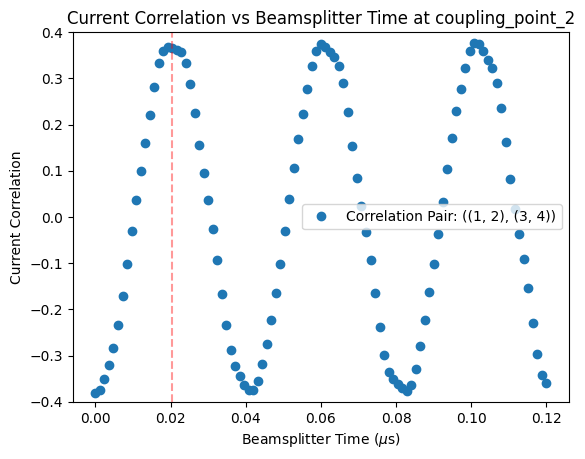

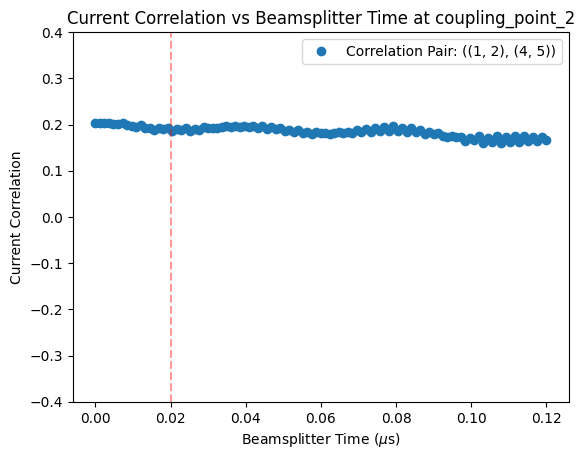

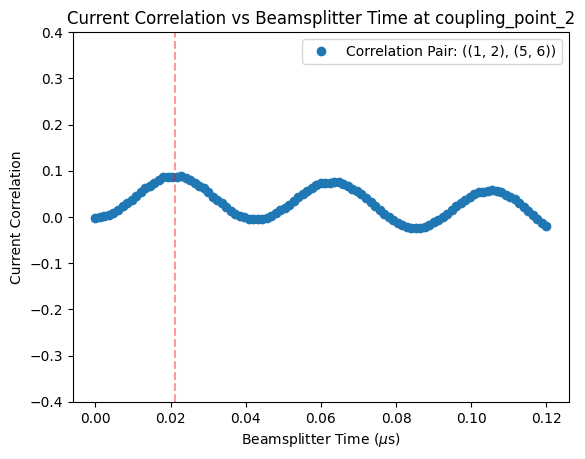

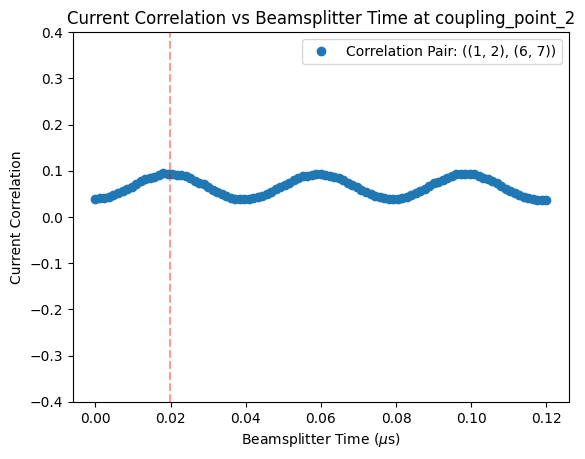

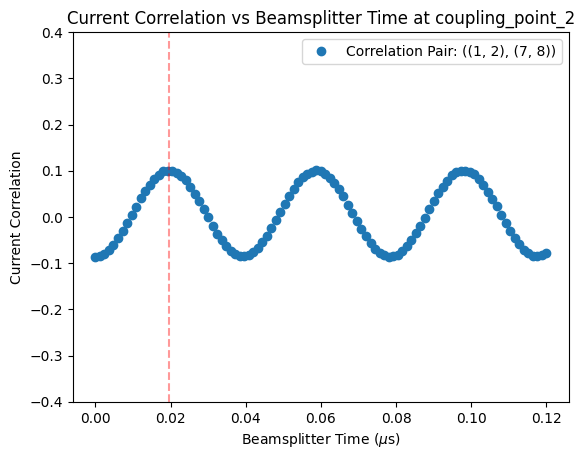

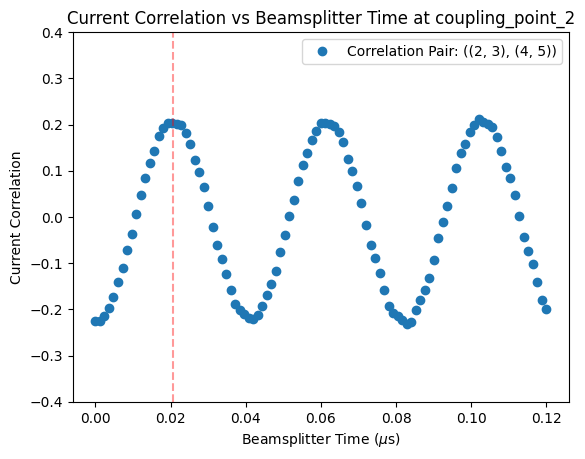

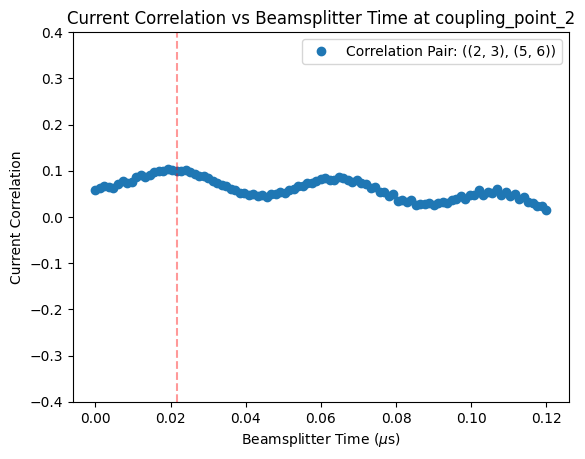

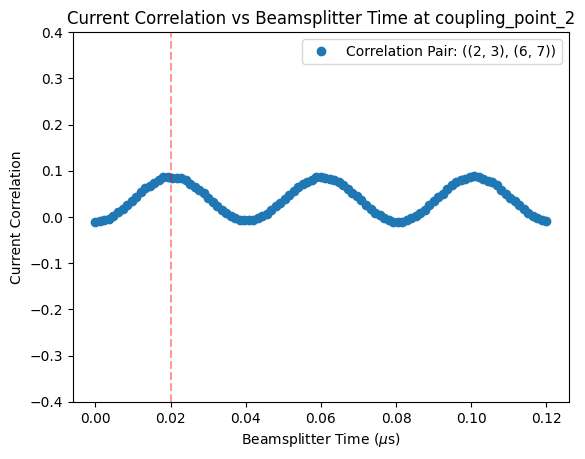

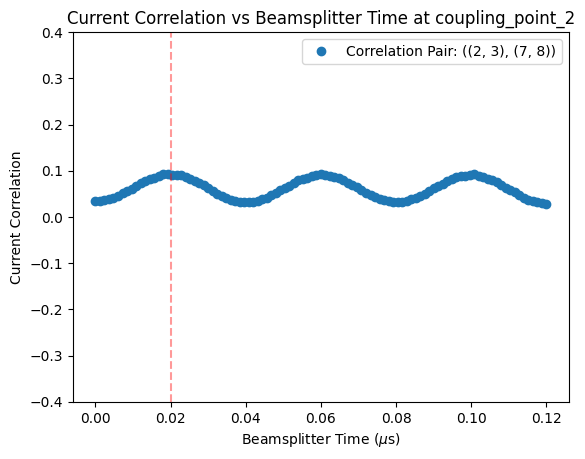

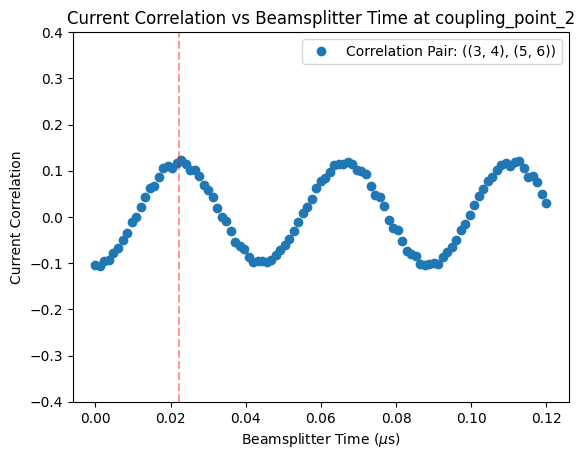

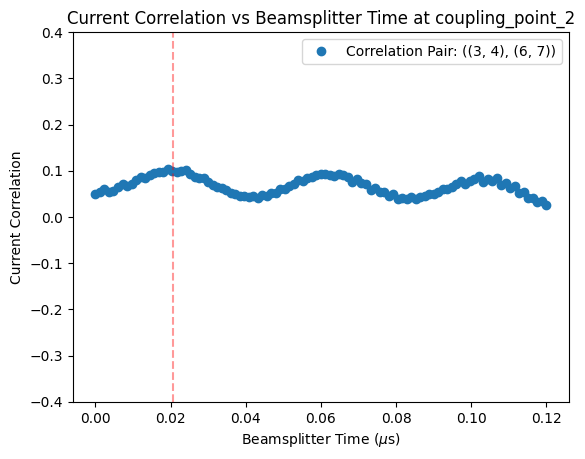

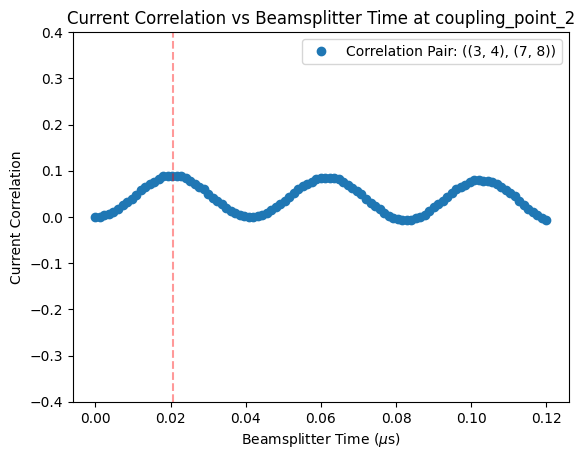

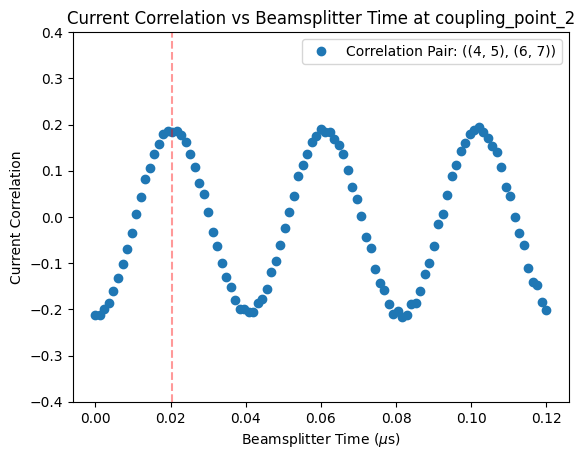

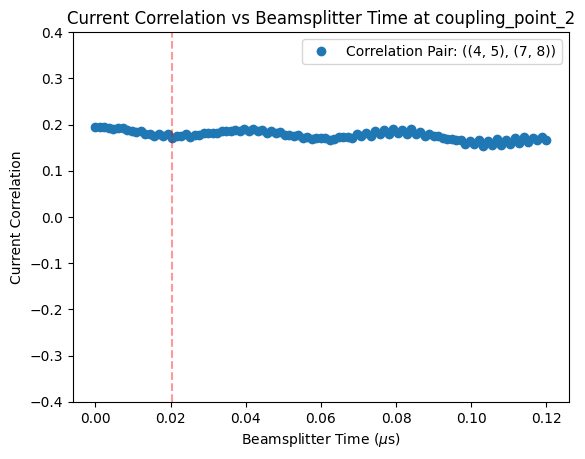

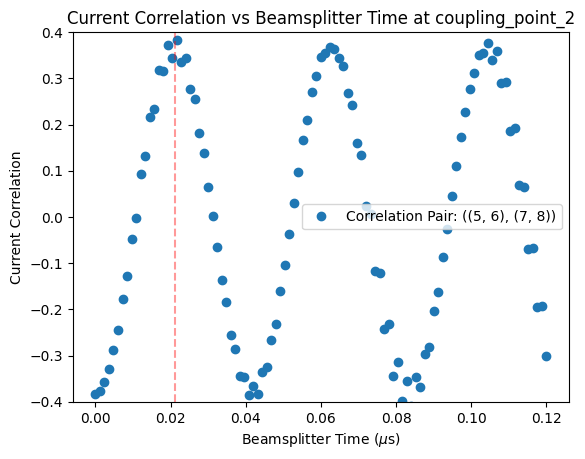

In [161]:
for correlation_pair in correlation_pairs:

    current_correlation = correlation_pair_to_current_correlation[correlation_pair]

    beamsplitter_time_simulation = correlation_pair_to_beamsplitter_time[correlation_pair]

    plt.plot(times, current_correlation, linestyle='', marker='o', label=f'Correlation Pair: {correlation_pair}')
    plt.xlabel('Beamsplitter Time ($\mu$s)')
    plt.ylabel('Current Correlation')
    plt.title(f'Current Correlation vs Beamsplitter Time at {coupling_point}')

    plt.ylim(-0.4, 0.4)

    plt.axvline(beamsplitter_time_simulation, color='r', alpha=0.4, linestyle='--')

    plt.legend()
    plt.show()
    

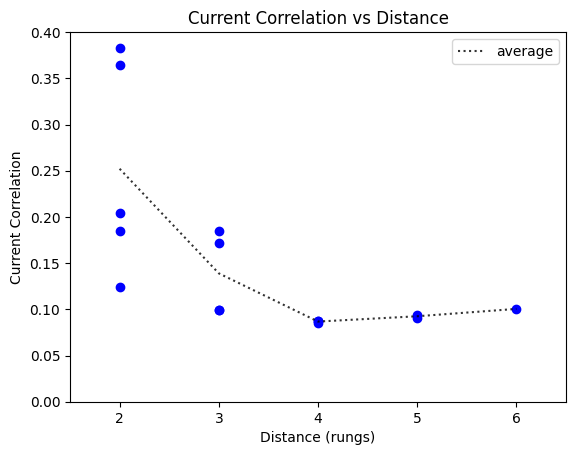

In [164]:
current_correlation_by_distance = {}


for correlation_pair in correlation_pairs:

    current_correlation_value = correlation_pair_to_current_correlation_value[correlation_pair]

    distance = abs(min(correlation_pair[0]) - min(correlation_pair[1]))

    if not distance in current_correlation_by_distance:
        current_correlation_by_distance[distance] = []
    
    current_correlation_by_distance[distance].append(current_correlation_value)


distances = []
current_correlation_averages = []

for distance in current_correlation_by_distance:
    distances.append(distance)
    current_correlation_averages.append(np.mean(current_correlation_by_distance[distance]))

# plot
for distance in current_correlation_by_distance:
    plt.scatter([distance]*len(current_correlation_by_distance[distance]), current_correlation_by_distance[distance], color='b')

plt.plot(distances, current_correlation_averages, linestyle=':', color='black', alpha=0.8, label='average')

plt.xlabel('Distance (rungs)')
plt.xticks([2, 3, 4, 5, 6])


plt.ylabel('Current Correlation')

plt.legend()

plt.xlim(1.5, 6.5)
plt.ylim(0, 0.4)

plt.title('Current Correlation vs Distance')



plt.show()

In [166]:
data_dictionary = {}

for correlation_pair in correlation_pairs:

    data_dictionary[correlation_pair] = {}


    data_dictionary[correlation_pair]['beamsplitter_time'] = correlation_pair_to_beamsplitter_time[correlation_pair]

    data_dictionary[correlation_pair]['current_correlation'] = correlation_pair_to_current_correlation[correlation_pair]
    data_dictionary[correlation_pair]['current_correlation_value'] = correlation_pair_to_current_correlation_value[correlation_pair]


In [167]:
def backup_data(data_filename):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename_only = os.path.basename(data_filename)
    name, ext = os.path.splitext(filename_only)
    backup_name = f"{name}_{timestamp}{ext}"
    backup_path = os.path.join('data_backups', backup_name)
    shutil.copy2(data_filename, backup_path)

def save_nested_dict_to_hdf5(filename, data, save_backup=True):

    if save_backup:
        backup_data(filename)

    with h5py.File(filename, 'w') as f:
        def _save_dict(group, dictionary):
            for key, value in dictionary.items():
                if isinstance(value, dict):
                    subgroup = group.create_group(str(key))
                    _save_dict(subgroup, value)
                elif isinstance(value, np.ndarray):
                    group.create_dataset(key, data=value, compression='gzip')
                elif isinstance(value, list):
                    group.create_dataset(key, data=np.array(value), compression='gzip')
                else:
                    group.attrs[key] = value  # Store scalars as attributes
        
        _save_dict(f, data)

def update_data_file(filename, data, keys, save_backup=True):
    if save_backup:
        backup_data(filename)
    
    with h5py.File(filename, 'a') as f:  # Open in append mode
        def _navigate_to_parent(group, key_path):
            """Navigate to the parent group of the target location"""
            current_group = group
            for key in key_path[:-1]:  # All keys except the last one
                if str(key) in current_group:
                    current_group = current_group[str(key)]
                else:
                    # Create the group if it doesn't exist
                    current_group = current_group.create_group(str(key))
            return current_group
        
        def _save_data_at_location(group, key, value):
            """Save data at a specific location, replacing if it exists"""
            # Remove existing data if it exists
            if key in group:
                del group[key]
            
            # Save new data
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                _save_dict(subgroup, value)
            elif isinstance(value, np.ndarray):
                group.create_dataset(key, data=value, compression='gzip')
            elif isinstance(value, list):
                group.create_dataset(key, data=np.array(value), compression='gzip')
            else:
                group.attrs[key] = value  # Store scalars as attributes
        
        def _save_dict(group, dictionary):
            """Helper function to save nested dictionaries"""
            for key, value in dictionary.items():
                _save_data_at_location(group, str(key), value)
        
        # Navigate to the parent location
        parent_group = _navigate_to_parent(f, keys)
        
        # Save the data at the final key location
        final_key = str(keys[-1])
        _save_data_at_location(parent_group, final_key, data)

In [ ]:
# data_filename = 'current_correlations_data.h5'

# this overwrits the whole file !!! be careful
# save_nested_dict_to_hdf5(data_filename, {coupling_point: data_dictionary})

In [168]:
data_filename = 'current_correlations_data.h5'

keys = ('simulation', 'highest', 'no_dephasing', coupling_point)

update_data_file(data_filename, data_dictionary, keys=keys, save_backup=True)
